# Learning and inference with the task model

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import task_generation, task_model, tqdm, plots

plots.set_rcparams()

color_dict = {
    'DM_ANTI': '#2b8a3e',
    'DM_PRO': '#f59f00',
    'PRO_M': '#b30000',
    'PRO_D': '#be4bdb',
    'ANTI_M': '#364fc7',
    'ANTI_D': '#21B8CF',
}

In [8]:
# choose a subset of tasks to learn
# task_list = ['DM_PRO', 'PRO_D', 'DM_ANTI', 'ANTI_D', 'PRO_M', 'ANTI_M']
task_list = ['ANTI_D', 'DM_PRO', 'PRO_D', 'PRO_M', 'ANTI_M', 'DM_ANTI']
# task_list = ['PRO_R', 'PRO_D', 'ANTI_R', 'ANTI_D']
# task_list = ['ANTI_D', 'PRO_M', 'PRO_D', 'ANTI_M']
n_trials = 192  # number of trials. these will be evenly split between the tasks.
nx = 8  # possible values of x. Could be more than 2.
sigma = 0.05  # observational noise
p_stay = 0.9  # probability of staying in the same epoch
min_Te = 5  # minimum duration of each epoch
random_x_order = True  # whether to randomize the order of x values in each trial
flip_fixation = True  # whether to flip the fixation epoch

np.random.seed(0)

trials, epoch_list, epoch_boundaries = task_generation.generate_trials(
    task_list, n_trials, nx, sigma, p_stay, min_Te,
    trial_order='blocked', random_x_order=random_x_order,
    flip_fixation=flip_fixation)

nc = len(task_list)  # number of tasks in the dataset
nz = len(epoch_list)  # number of epoch types in the dataset

true_Lambda, true_Q, true_Pi = task_generation.get_ground_truth(
    task_list, epoch_list, p_stay=p_stay, nx=nx)

num_epochs_each_task = [len(np.unique(task_generation.task_dict[task_type].\
                                      split('->'))) for task_type in task_list]

# store what a fixation epoch looks like
q_fixate = task_generation.make_delay_or_fixation_epoch(
    None, 1, 0, 0, d_stim=np.pi/2)
if flip_fixation:
    q_fixate['s'][0, -1] = 1 - q_fixate['s'][0, -1]
    q_fixate['y'][0, -1] = 1 - q_fixate['y'][0, -1]
    true_Q[:, :, 4] = 1 - true_Q[:, :, 4]
    true_Q[:, :, -1] = 1 - true_Q[:, :, -1]
q_fixate = np.concatenate([q_fixate['s'], q_fixate['y']], axis=1)


In [4]:

model = task_model.TaskModel(
    nc=nc, nz=nz, nx=nx, sigma=sigma, d=q_fixate.shape[-1],
    n_epochs_each_task=num_epochs_each_task,
    q_fixate=q_fixate)

model.Q = np.ones_like(model.Q) * -1

inferred_z_during_learning = []
inferred_z_during_learning_test_mode = []
LL_over_trials_across_time = np.zeros((n_trials, n_trials))
LL_over_trials_across_time_forward_only = np.zeros((n_trials, n_trials))

Qs = []

for itrial, trial in enumerate(tqdm.tqdm(trials)):

    model.incremental_initialize_Q(trial)
    model.learn_single_trial(trial)

    if trial[0] == 1:
        Qs.append(model.Q.copy())

    # evaluate on all trials
    LLs = []
    LLs_forward_only = []
    inferred_z_during_learning.append([])
    inferred_z_during_learning_test_mode.append([])
    for _trial in trials:
        gamma, LL = model.infer(_trial, use_y=True)
        inferred_z_during_learning[-1].append(gamma.sum(0).sum(0))
        LLs.append(LL)

        gamma, LL = model.infer(_trial, use_y=False, forward_only=True)
        inferred_z_during_learning_test_mode[-1].append(
            gamma.sum(0).sum(0))
        LLs_forward_only.append(LL)

    LL_over_trials_across_time[itrial] = np.array(LLs)
    LL_over_trials_across_time_forward_only[itrial] = np.array(LLs_forward_only)


100%|██████████| 192/192 [02:51<00:00,  1.12it/s]


In [9]:
inferred_z_after_learning = []
inferred_z_after_learning_test_mode = []
for _, trial in enumerate(trials):
    gamma, LL = model.infer(trial, use_y=True, forward_only=False)
    inferred_z_after_learning.append(gamma.sum(0).sum(0))
    gamma, LL = model.infer(trial, use_y=False, forward_only=True)
    inferred_z_after_learning_test_mode.append(gamma.sum(0).sum(0))


LL_over_trials_across_time_true_params = np.zeros((n_trials))
LL_over_trials_across_time_true_params_forward_only = np.zeros((n_trials))
for itrial, trial in enumerate(trials):
    gamma, _, _, LL = task_model.get_stats_for_single_trial(
        single_trial=trial,
        Q=true_Q,
        Lambda=true_Lambda,
        Pi=true_Pi,
        x_oracle=False,
        sigma=sigma)
    LL_over_trials_across_time_true_params[itrial] = LL

    gamma, _, _, LL = task_model.get_stats_for_single_trial(
        single_trial=trial,
        Q=true_Q,
        Lambda=true_Lambda,
        Pi=true_Pi,
        x_oracle=False,
        sigma=sigma,
        forward_only=True, show_y=False)
    LL_over_trials_across_time_true_params_forward_only[itrial] = LL
    
avg_LL_each_task_true_params = LL_over_trials_across_time_true_params.reshape(nc, -1).mean(1)
avg_LL_each_task_true_params_forward_only = LL_over_trials_across_time_true_params_forward_only.reshape(nc, -1).mean(1)

## Inferred posterior over z for an example trial

[5 0]


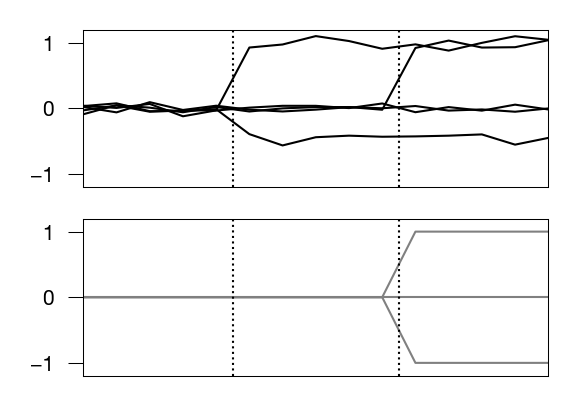

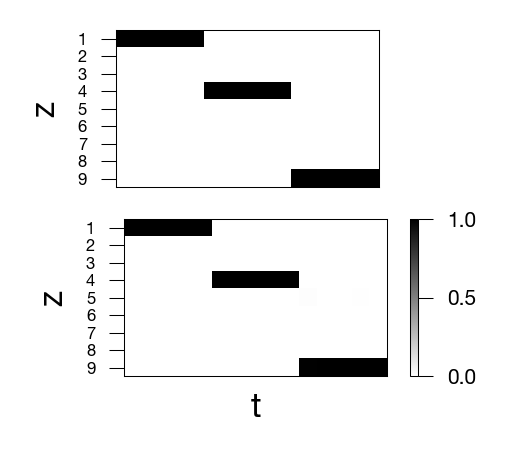

In [10]:
trial_ind = 165
print(trials[trial_ind][:2])
trial_length = len(trials[trial_ind][2]['s'])
boundaries = np.array(epoch_boundaries[trial_ind])
_, axes = plt.subplots(ncols=1, nrows=2, sharex=True)
axes = axes.flatten()

plt.sca(axes[0])
plt.plot(np.arange(trial_length) + 1, trials[trial_ind][2]['s'], color='k', )
plt.ylim(-1.2, 1.2)
plt.xlim(1, trial_length)
for b in boundaries:
    plt.axvline(b + 0.5, color='k', linestyle=':', linewidth=0.5)

plt.sca(axes[1])
plt.plot(np.arange(trial_length) + 1, trials[trial_ind][2]['y'], color='gray')
plt.ylim(-1.2, 1.2)
plt.xlim(1, trial_length)  
for b in boundaries:
    plt.axvline(b + 0.5, color='k', linestyle=':', linewidth=0.5)
plt.xticks([])
plt.savefig('Figures/trial_example_stimulus.svg', dpi=300)

_, axes = plt.subplots(ncols=1, nrows=2, sharex=True)

plt.sca(axes[0])

plt.imshow(inferred_z_during_learning[trial_ind][trial_ind],
           interpolation='none', cmap='gray_r')
plt.yticks(np.arange(nz), np.arange(nz) + 1, fontsize=4)

plt.ylabel('z')

plt.sca(axes[1])

plt.imshow(inferred_z_after_learning_test_mode[trial_ind],
           interpolation='none', cmap='gray_r')
plt.yticks(np.arange(nz), np.arange(nz) + 1, fontsize=4)
plt.colorbar()
plt.ylabel('z')
plt.xlabel('t')
plt.xticks([])

plt.savefig('Figures/trial_example.svg', dpi=300)

## Average log likelihood of each task as a function of trials learned

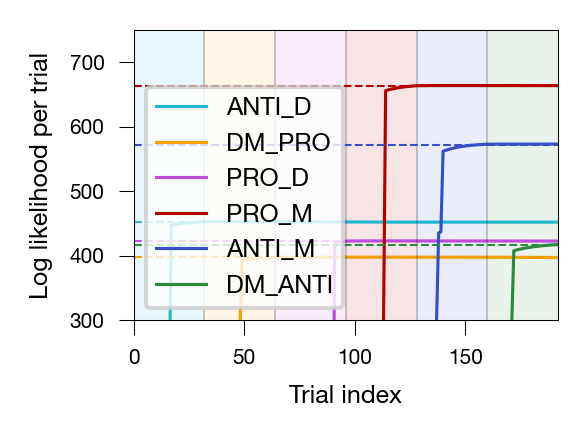

In [11]:
plt.figure(figsize=(2, 1.5), dpi=300)
n_trials_per_task = n_trials // nc

yrange = [300, 750]

for i in range(nc):
    plt.axvline(n_trials_per_task * i, color='k', alpha=0.2)
    trials_this_task = LL_over_trials_across_time.reshape(n_trials, nc, -1)[:, i, :]
    _ = plt.plot(1 + np.arange(n_trials), trials_this_task.mean(-1),
                 color=color_dict[task_list[i]], label=task_list[i], lw=0.75)
    plt.axhline(avg_LL_each_task_true_params[i], color=color_dict[task_list[i]], ls='--')
    plt.fill_betweenx(
        yrange,
        n_trials_per_task * i,
        n_trials_per_task * (i + 1),
        alpha=0.1, color=color_dict[task_list[i]], lw=0)
plt.legend(fontsize=6)

plt.ylim(yrange[0], yrange[1])
plt.xlim(0, n_trials)
plt.xlabel('Trial index', fontsize=6)
plt.ylabel('Log likelihood per trial', fontsize=6)
plt.tight_layout()
plt.savefig('Figures/LL_over_trials_across_time.svg', dpi=300)



# plt.ylim(0, 600)

(-1000.0, 350.0)

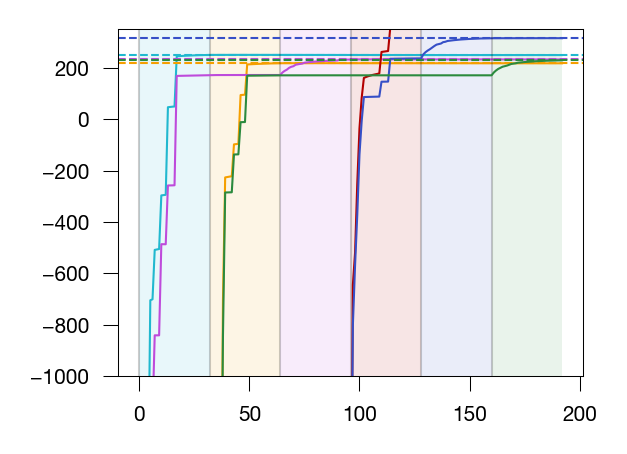

In [12]:
plt.figure(figsize=(2, 1.5), dpi=300)
y_range = [-1000, 350]
for i in range(nc):
    plt.axvline(n_trials_per_task * i, color='k', alpha=0.2)
    trials_this_task = LL_over_trials_across_time_forward_only.reshape(n_trials, nc, -1)[:, i, :]
    _ = plt.plot(1 + np.arange(n_trials), trials_this_task.mean(-1), color=color_dict[task_list[i]], label=task_list[i])
    plt.axhline(avg_LL_each_task_true_params_forward_only[i], color=color_dict[task_list[i]], ls='--')
    plt.fill_betweenx(
        y_range,
        n_trials_per_task * i,
        n_trials_per_task * (i + 1),
        alpha=0.1, color=color_dict[task_list[i]], lw=0)

plt.ylim(y_range[0], y_range[1])